The purpose of this notebook is to compare OpenDrift and OceanParcels drift trajectory outputs.

* Model fields and initiation positions from
  * runs_20160520-20160522_sct_N24/runs/kit500_od_2016052103_P1D

In [1]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, ScipyParticle
from glob import glob
from datetime import timedelta as delta
import datetime

import glob
import os

import xarray as xr
import matplotlib.pyplot as plt
import yaml

import numpy as np
import cartopy.crs as ccrs

In [2]:
run_dir='/home/soontiensn/data/gpsc-work7/OPP/DriftEval-portmodels/kit/ocean-parcels-compare/'
exp='runs_20160520-20160522_sct_N24/runs/kit500_od_2016052103_P1D'
positions_file = os.path.join(run_dir, 'rotation-error', 'drifter_positions.yaml')

ocean_dir = os.path.join(run_dir, 'rotation-error', 'ocean')
atmos_dir = os.path.join(run_dir, 'rotation-error', 'atmos')
mesh = os.path.join(run_dir, 'rotation-error', 'mesh.nc')

In [3]:
with open(positions_file, 'r') as f:
    positions=yaml.load(f, Loader=yaml.FullLoader)
positions = positions['drifter_grid_positions']
lons = []
lats = []
for key in positions:
    lon,lat,_,datestr = positions[key]
    lons.append(lon)
    lats.append(lat)

In [4]:
lons

[-129.5529146146661,
 -129.5528117750303,
 -129.55258962774866,
 -129.5525545090667]

# Prepare ocean data

In [5]:
ufiles = sorted(glob.glob(os.path.join(ocean_dir, 'xwater*.nc')))
vfiles = sorted(glob.glob(os.path.join(ocean_dir, 'ywater*.nc')))

filenames = {'U': {'lon': mesh, 'lat': mesh, 'depth': mesh, 'data': ufiles},
             'V': {'lon': mesh, 'lat': mesh, 'depth': mesh, 'data': vfiles},}

variables = {'U': 'uos',
             'V': 'vos'}
dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'},
              'V': {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'},}

ocean_fieldset = FieldSet.from_nemo(filenames, variables, dimensions)


# Prepare wind data

In [6]:
wind_files = sorted(glob.glob(os.path.join(atmos_dir, '*.nc')))

In [7]:
dtry = xr.open_mfdataset(wind_files)
#dtry = dtry.isel(x=slice(1500,2500), y=slice(0,1200))

u = dtry.u_wind.values
v = dtry.v_wind.values
nav_lon = dtry.nav_lon.values[0]
nav_lat = dtry.nav_lat.values[0]
time = dtry.time_counter.values

In [8]:
nav_lon[nav_lon>180] = nav_lon[nav_lon>180]-360

In [9]:
windage=0
variables = {'U': windage*u,
             'V': windage*v}
dimensions = {'U': {'lon': nav_lon, 'lat': nav_lat, 'time': time},
              'V': {'lon': nav_lon, 'lat': nav_lat, 'time': time},}


wind_fieldset = FieldSet.from_data(variables, dimensions)

# Set up particles

In [10]:
fieldset = FieldSet(U=ocean_fieldset.U+wind_fieldset.U, 
                    V=ocean_fieldset.V+wind_fieldset.V)


pset = ParticleSet.from_list(fieldset=fieldset, pclass=JITParticle,
                             lon=lons,
                             lat=lats,
                             time=datetime.datetime(2016,5,21,3),
                             depth=None)

In [11]:
outfile='ocean_parcels_test_kit500_nowinds.zarr'
kernels = pset.Kernel(AdvectionRK4)
output_file = pset.ParticleFile(name=outfile, outputdt=delta(hours=1))
pset.execute(kernels, runtime=delta(hours=24), dt=delta(seconds=60),output_file=output_file)
output_file.close() 

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /tmp/parcels-1000/lib9742a2b7978ae1104cfb0eef3c9ee90e_0.so
INFO: Output files are stored in ocean_parcels_test_kit500_nowinds.zarr.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 86400.0/86400.0 [00:26<00:00, 3201.34it/s]


In [12]:
OP = xr.open_dataset(outfile)
OD = xr.open_dataset(os.path.join(run_dir,'../rotation-error/nowinds',exp,'OpenDrift_raw_trajectory_2016-05-21_03h.nc'))
corrected_dir = os.path.join(run_dir,'../correction/nowinds',exp)
OD_corrected = xr.open_dataset(os.path.join(corrected_dir,'OpenDrift_raw_trajectory_2016-05-21_03h.nc'))

/home/soontiensn/miniconda-new/envs/py3_parcels/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/soontiensn/miniconda-new/envs/py3_parcels/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [13]:
OP

<xarray.Dataset>
Dimensions:     (trajectory: 4, obs: 25)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * trajectory  (trajectory) int64 0 1 2 3
Data variables:
    lat         (trajectory, obs) float64 ...
    lon         (trajectory, obs) float64 ...
    time        (trajectory, obs) datetime64[ns] ...
    z           (trajectory, obs) float64 ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.0

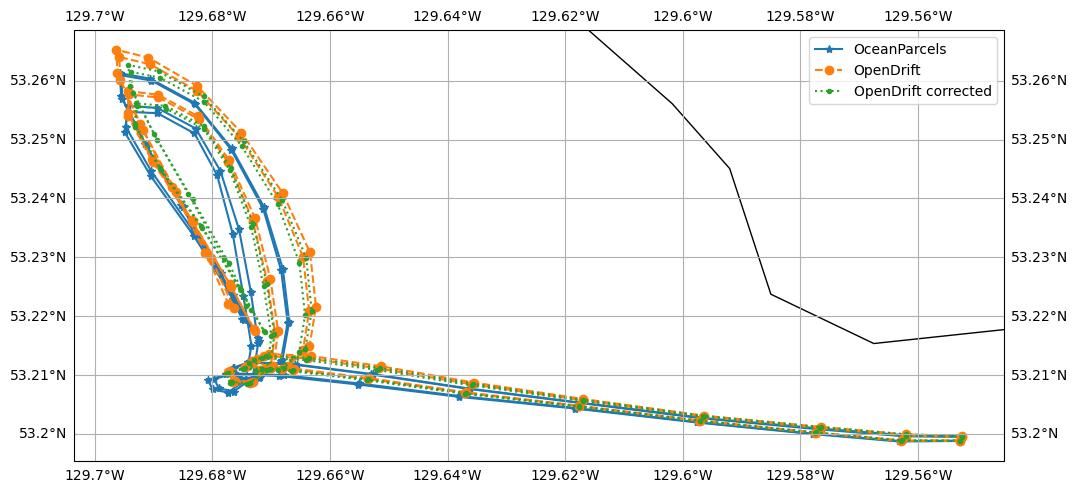

In [14]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
count=0
for t in OP.trajectory.values:
    label='OceanParcels' if count==0 else '_nolabel'
    dsel=OP.sel(trajectory=t)
    ax.plot(dsel.lon.values, dsel.lat.values, '*-C0', label=label,transform=ccrs.PlateCarree())
    count+=1
count=0
for t in OD.ntraj.values:
    label='OpenDrift' if count==0 else '_nolabel'
    dsel=OD.sel(ntraj=t)
    ax.plot(dsel.lon.values, dsel.lat.values, 'o--C1', label=label, transform=ccrs.PlateCarree())
    count+=1
count=0
for t in OD_corrected.ntraj.values:
    label='OpenDrift corrected' if count==0 else '_nolabel'
    dsel=OD_corrected.sel(ntraj=t)
    ax.plot(dsel.lon.values, dsel.lat.values, '.:C2', label=label, transform=ccrs.PlateCarree())
    count+=1
ax.legend()
ax.coastlines()
ax.gridlines(draw_labels=True)

## Differences between OpenDrift and OceanParcels

* Look at the distances between pairs vs distance travelled
* only for corrected OpenDrift

In [15]:
from geopy.distance import distance

In [16]:
sep_orig = np.zeros_like(OD.lon.values)
sep_corrected = np.zeros_like(OD_corrected.lon.values)
OD_corrected_distance_travelled = np.zeros_like(OD_corrected.lon.values)
OD_distance_travelled = np.zeros_like(OD.lon.values)
OP_distance_travelled = np.zeros_like(OP.lon.values)
for i in range(sep_orig.shape[0]):
    for t in range(sep_orig.shape[1]):
        sep_orig[i,t] = distance((OD.lat.values[i,t],OD.lon.values[i,t]), 
                            (OP.lat.values[i,t],OP.lon.values[i,t])).meters
        sep_corrected[i,t] = distance((OD_corrected.lat.values[i,t],OD_corrected.lon.values[i,t]), 
                            (OP.lat.values[i,t],OP.lon.values[i,t])).meters
        if t >=1:
            OD_distance_travelled[i,t] = OD_distance_travelled[i,t-1] + \
                                            distance((OD.lat.values[i,t-1],OD.lon.values[i,t-1]), 
                                                     (OD.lat.values[i,t],OD.lon.values[i,t])).meters
            OD_corrected_distance_travelled[i,t] = OD_corrected_distance_travelled[i,t-1] + \
                                            distance((OD_corrected.lat.values[i,t-1],OD_corrected.lon.values[i,t-1]), 
                                                     (OD_corrected.lat.values[i,t],OD_corrected.lon.values[i,t])).meters
            OP_distance_travelled[i,t] = OP_distance_travelled[i,t-1] + \
                                            distance((OP.lat.values[i,t-1],OP.lon.values[i,t-1]), 
                                                     (OP.lat.values[i,t],OP.lon.values[i,t])).meters
        

In [17]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
count=0
label1='OceanParcels'
label2='OpenDrift-original'
label3='OpenDrift-corrected'
for i, c in zip(range(sep_orig.shape[0]), ['C0', 'C1', 'C2', 'C3', 'C4']):
    if count!=0:
        label1='__nolabel'
        label2='__nolabel'
        label3='__nolabel'
    axs[0].plot(sep_orig[i,:],'--',color=c,label=label2)
    axs[0].plot(sep_corrected[i,:],':',color=c,label=label3)
    axs[1].plot(OP_distance_travelled[i,:],color=c,label=label1)
    axs[1].plot(OD_distance_travelled[i,:],'--',color=c, label=label2)
    axs[1].plot(OD_corrected_distance_travelled[i,:],':',color=c, label=label3)
    count+=1
axs[0].set_ylabel('separation distance [m]')
axs[0].set_xlabel('forecast hour')
axs[0].set_title('Distance between OpenDrift particle \n and OceanParcels particle over time')
axs[0].legend()
axs[0].grid()

axs[1].set_ylabel('distance travelled [m]')
axs[1].set_xlabel('forecast hour')
axs[1].set_title('Distance travelled by particle over time')
axs[1].legend()
axs[1].grid()

# Summary
* For this cases, the OpenDrift and OceanParcels trajectories are very similar, even with the rotation error.
* After 24 hours, the max separation distance is about 400m for the OpenDrift particles with the rotation error and 300m for the OpenDrift particles with the rotation error corrected. This is nearly 0.1% of the total distance travelled and appears to be related to differences in land treatment and or interpolation of ocean currents near land. 